In [34]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# ====================================================
# 1. Base Dataset (One Day per Sample)
# ====================================================
class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # Process location group information (we won’t use it here so you may ignore it)
        location_group = data['location_group']  # shape: (1, 3)
        location_ids = data['location_ids'].flatten()  # shape: (37,)
        num_stations = len(location_ids)  # should be 37

        # Create an array to store the group ID for each station
        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-indexed
            group_ids[station_indices] = i + 1  # assign group number (1, 2, 3)
        self.group_ids = group_ids  # not used in our location-level training below

        # Load training or testing data based on flag
        if train:
            X_data = data['X_tr']  # shape: (1, num_train), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, num_train)
        else:
            X_data = data['X_te']  # shape: (1, num_test), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, num_test)

        # Convert cell arrays into lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # Returns one day's data:
        # x: shape (37, 11), y: shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        # Optionally, if you want to add group info you could, but here we simply use the raw 11 features.
        # x currently has shape (37, 11)
        if self.transform:
            x = self.transform(x)
        return x, y

# ====================================================
# 2. Location-Level Dataset Wrapper
# ====================================================
class WaterQualityLocationDataset(Dataset):
    def __init__(self, base_dataset):
        """
        Wraps a WaterQualityDataset (one day per sample) and splits each day into 37 individual samples.
        Each sample corresponds to one location.
        """
        self.base_dataset = base_dataset
        self.num_days = len(base_dataset)
        self.num_locations = 37  # assuming always 37 locations

    def __len__(self):
        return self.num_days * self.num_locations

    def __getitem__(self, idx):
        # Map the overall index to a day and a location within that day.
        day_idx = idx // self.num_locations
        loc_idx = idx % self.num_locations
        X_day, Y_day = self.base_dataset[day_idx]  # X_day: shape (37, 11), Y_day: shape (37,)
        # Extract the location's features (use only the 11 features; ignore any appended group info)
        x = X_day[loc_idx, :]  # shape: (11,)
        y = Y_day[loc_idx]     # scalar
        # Return day and location indices too (for later grouping in visualization)
        return x, y, day_idx, loc_idx

# ====================================================
# 3. Simple MLP Model for Location-Level Prediction
# ====================================================
class DeepLocationMLP(nn.Module):
    def __init__(self, input_dim=11, hidden_dims=[128,256,128], output_dim=1):
        super(DeepLocationMLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 11)
        return self.net(x)


# ====================================================
# 4. Training, Evaluation, and Visualization Functions
# ====================================================
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_x, batch_y, _, _ in pbar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze(1)  # shape: (batch_size,)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.6f}")
    return running_loss / len(train_loader.dataset)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x).squeeze(1)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
    return running_loss / len(test_loader.dataset)

def visualize_day(model, dataset, device, day_index):
    """
    Plots the predictions vs. true values for all locations in a given day.
    """
    # Filter out samples belonging to the specified day_index.
    # Since our dataset returns (x, y, day_idx, loc_idx), we can collect samples for day_index.
    xs = []
    ys = []
    # Since the dataset is small, we can loop over it:
    for i in range(len(dataset)):
        x, y, d_idx, _ = dataset[i]
        if d_idx == day_index:
            xs.append(x.unsqueeze(0))
            ys.append(torch.tensor([y]))
    if not xs:
        print(f"No data found for day {day_index}")
        return
    xs = torch.cat(xs, dim=0).to(device)  # shape: (37, 11)
    with torch.no_grad():
        predictions = model(xs)  # shape: (37, 1)
    predictions = predictions.squeeze(1).cpu().numpy()
    true_vals = torch.cat(ys, dim=0).squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.plot(true_vals, label="True", marker='o')
    plt.plot(predictions, label="Predicted", marker='x')
    plt.title(f"True vs Predicted Water Quality for Day {day_index}")
    plt.xlabel("Location Index")
    plt.ylabel("Water Quality (pH)")
    plt.legend()
    plt.grid(True)
    plt.show()




In [35]:
# ====================================================
# 5. Main Training Loop
# ====================================================

# File path for the dataset
mat_file_path = 'water_dataset.mat'  # Replace with your actual file path

batch_size = 16  # Adjust based on your dataset size
# Create the base dataset (one day per sample)
base_train_dataset = WaterQualityDataset(mat_file_path, train=True)
base_test_dataset = WaterQualityDataset(mat_file_path, train=False)

# Wrap the base datasets into location-level datasets (each sample is one location in one day)
train_dataset = WaterQualityLocationDataset(base_train_dataset)
test_dataset = WaterQualityLocationDataset(base_test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss function, optimizer, and learning rate scheduler
model =  model = DeepLocationMLP(hidden_dims=[64,64]).to(device)
criterion = nn.MSELoss()  # You can also try SmoothL1Loss, etc.
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    scheduler.step(test_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, LR: {current_lr:.8f}")





Epoch 1/30 -- Train Loss: 0.00470251, Test Loss: 0.00021085, LR: 0.00100000


Epoch 2/30 -- Train Loss: 0.00021436, Test Loss: 0.00026507, LR: 0.00100000


Epoch 3/30 -- Train Loss: 0.00020493, Test Loss: 0.00018995, LR: 0.00100000


Epoch 4/30 -- Train Loss: 0.00019805, Test Loss: 0.00016521, LR: 0.00100000


Epoch 5/30 -- Train Loss: 0.00019276, Test Loss: 0.00017270, LR: 0.00100000


Epoch 6/30 -- Train Loss: 0.00019867, Test Loss: 0.00020168, LR: 0.00100000


Epoch 7/30 -- Train Loss: 0.00017769, Test Loss: 0.00015474, LR: 0.00100000


Epoch 8/30 -- Train Loss: 0.00017575, Test Loss: 0.00019331, LR: 0.00100000


Epoch 9/30 -- Train Loss: 0.00018294, Test Loss: 0.00019103, LR: 0.00100000


Epoch 10/30 -- Train Loss: 0.00016523, Test Loss: 0.00017096, LR: 0.00100000


Epoch 11/30 -- Train Loss: 0.00016637, Test Loss: 0.00021391, LR: 0.00010000


Epoch 12/30 -- Train Loss: 0.00012908, Test Loss: 0.00012322, LR: 0.00010000


Epoch 13/30 -- Train Loss: 0.00012800, Test Loss: 0.00012360, LR: 0.00010000


Epoch 14/30 -- Train Loss: 0.00012775, Test Loss: 0.00012535, LR: 0.00010000


Epoch 15/30 -- Train Loss: 0.00012805, Test Loss: 0.00013021, LR: 0.00010000


Epoch 16/30 -- Train Loss: 0.00012748, Test Loss: 0.00012348, LR: 0.00001000


Epoch 17/30 -- Train Loss: 0.00012158, Test Loss: 0.00012204, LR: 0.00001000


Epoch 18/30 -- Train Loss: 0.00012131, Test Loss: 0.00012219, LR: 0.00001000


Epoch 19/30 -- Train Loss: 0.00012141, Test Loss: 0.00012118, LR: 0.00001000


Epoch 20/30 -- Train Loss: 0.00012126, Test Loss: 0.00012160, LR: 0.00001000


Epoch 21/30 -- Train Loss: 0.00012116, Test Loss: 0.00012047, LR: 0.00001000


Epoch 22/30 -- Train Loss: 0.00012116, Test Loss: 0.00012058, LR: 0.00001000


Epoch 23/30 -- Train Loss: 0.00012096, Test Loss: 0.00012047, LR: 0.00001000


Epoch 24/30 -- Train Loss: 0.00012084, Test Loss: 0.00012241, LR: 0.00001000


Epoch 25/30 -- Train Loss: 0.00012094, Test Loss: 0.00012016, LR: 0.00001000


Epoch 26/30 -- Train Loss: 0.00012082, Test Loss: 0.00012151, LR: 0.00001000


Epoch 27/30 -- Train Loss: 0.00012079, Test Loss: 0.00012030, LR: 0.00001000


Epoch 28/30 -- Train Loss: 0.00012047, Test Loss: 0.00012014, LR: 0.00001000


Epoch 29/30 -- Train Loss: 0.00012066, Test Loss: 0.00012063, LR: 0.00001000


Epoch 30/30 -- Train Loss: 0.00012040, Test Loss: 0.00012048, LR: 0.00001000


In [36]:
def visualize_random_day(model, dataset, device):
    """
    Randomly selects a day from the dataset and plots true vs. predicted values for all locations.
    Args:
        model: The trained model.
        dataset: A WaterQualityLocationDataset instance.
        device: The device (cpu or cuda).
    """
    # Randomly choose a day index between 0 and num_days - 1
    random_day = random.randint(0, dataset.num_days - 1)
    print(f"Visualizing results for random day: {random_day}")
    visualize_day(model, dataset, device, day_index=random_day)

Visualizing results for random day: 280


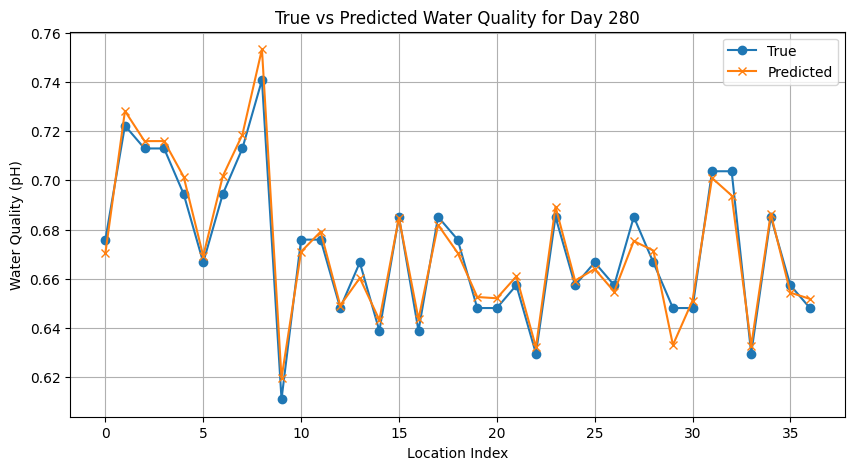

In [42]:
visualize_random_day(model, test_dataset, device)